#### Loading Libraries

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pylab as plt
from scipy.stats import truncexpon
import pickle5 as pkl

from functools import partial
from multiprocessing import Pool, cpu_count
from PIL import Image

#### Plotting images

In [2]:
%run '/home/renat_sergazinov/python-git-workspace/PhotoForceReconML/photoelastic_response.py'
%run '/home/renat_sergazinov/python-git-workspace/PhotoForceReconML/predictions_test_functions.py'

In [3]:
# select and form forces for force list
y_lai_select = [[0, np.pi], 
                [0, 2 * np.pi / 3, 4 * np.pi / 3], 
                [0, np.pi / 2, np.pi, 3 * np.pi / 2],
                [0, np.pi / 3, 2 * np.pi / 3, np.pi, 4 * np.pi / 3, 5 * np.pi / 3]]
y_lat_select = [[0, 0], [0,0,0], [0,0,0,0], [0,0,0,0,0,0]]
y_lm_select = [[0.3, 0.3], 
               [0.43, 0.43, 0.43], 
               [0.389, 0.389, 0.389, 0.389],
               [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]
F = generate_F_lists(y_lai_select, y_lat_select, y_lm_select, [2, 3, 4, 6])

In [4]:
# preset particle parameters
r1 = 0.004
r2 = 0.008
height = 0.005
particle1 = Particle(r1, height)
particle2 = Particle(r2, height)
f_sigma = 11000
px2m = 0.00019
pixels_per_radius1 = int(round(r1 / px2m))
pixels_per_radius2 = int(round(r2 / px2m))
cutoff = np.infty

In [5]:
#initializing multiprocessing
num_processes = cpu_count()
pool = Pool(processes = num_processes)
#generate particles
image_gen_preset1 = partial(photo_elastic_response_on_particle, particle1, 
                               f_sigma, pixels_per_radius1, cutoff)
image_gen_preset2 = partial(photo_elastic_response_on_particle, particle2, 
                               f_sigma, pixels_per_radius2, cutoff)
predict_images_small = np.array(pool.map(image_gen_preset1, F))
predict_images_big = np.array(pool.map(image_gen_preset2, F))

In [6]:
for i in range(len(predict_images_big)):
    plt.imsave(os.path.join(os.getcwd(), 'big_img' + str(i) + '.jpg'),
               np.asarray(predict_images_big[i]), vmin = 0, vmax = 1, cmap = 'gray')
for i in range(len(predict_images_small)):
    plt.imsave(os.path.join(os.getcwd(), 'small_img' + str(i) + '.jpg'),
               np.asarray(predict_images_small[i]), vmin = 0, vmax = 1, cmap = 'gray')

#### Make Histogram of Magnitudes

In [7]:
rv = truncexpon(b = (0.9-0.01) / 0.5, loc = 0.01, scale = 0.5)
mags = rv.rvs(100000000)

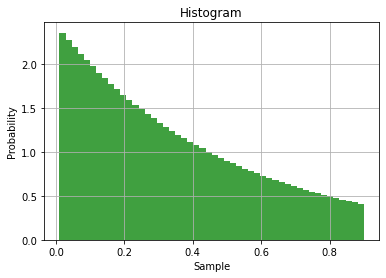

In [8]:
n, bins, patches = plt.hist(mags, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Sample')
plt.ylabel('Probability')
plt.title('Histogram')
plt.grid(True)
plt.show()

In [9]:
np.sum(np.diff(bins) * n)

1.0

In [10]:
np.mean(mags)

0.3294854981366644

#### Define paths

In [2]:
plots_path = os.path.join('/Users', 'renatsergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'model_testing', 'plots')

#### Preparing data

In [3]:
df_error_inner = pd.DataFrame()
df_error_inner["Number of forces"] = range(2, 7)
df_error_inner["VGG19"] = [0.0315, 0.0529, 0.0533,  0.0468, 0.0527]
df_error_inner["Xception"] = [0.0704, 0.1561, 0.2187, 0.2182, 0.2145]
df_error_inner["Inception"] = [0.0262, 0.1003, 0.1748 , 0.2309, 0.1839]
df_error_inner = pd.melt(df_error_inner, id_vars=["Number of forces"], value_name="Mean absolute error", var_name="Model")

In [4]:
df_error_tang = pd.DataFrame()
df_error_tang["Number of forces"] = range(2, 7)
df_error_tang["VGG19"] = [0.0220, 0.0391, 0.2325, 0.2190, 0.2227]
df_error_tang["Xception"] = [0.0307, 0.1040, 0.1632, 0.1705, 0.1777]
df_error_tang["Inception"] = [0.0167, 0.0930, 0.1273, 0.2188, 0.2250]
df_error_tang = pd.melt(df_error_tang, id_vars=["Number of forces"], value_name="Mean absolute error", var_name="Model")

In [5]:
df_error_mag = pd.DataFrame()
df_error_mag["Number of forces"] = range(2, 7)
df_error_mag["VGG19"] = [0.0139,0.0291,0.0302, 0.0345, 0.0379]
df_error_mag["Xception"] = [0.0071, 0.0318, 0.0551, 0.0441, 0.0487]
df_error_mag["Inception"] = [0.0037, 0.0208, 0.0378, 0.0352, 0.0423]
df_error_mag = pd.melt(df_error_mag, id_vars=["Number of forces"], value_name="Mean absolute error", var_name="Model")

#### Plot data

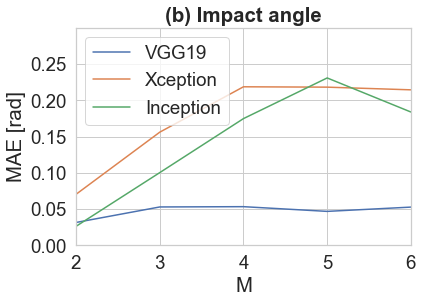

In [6]:
sns.set_theme(style="whitegrid", font_scale=1.7)
s = sns.lineplot(data=df_error_inner, x="Number of forces", y="Mean absolute error", hue="Model")
s.set(ylim = (0,0.3), xlim = (2,6))
s.set(xticks = np.arange(2,7,1))
s.set(yticks = np.arange(0,0.3,0.05))
s.set_title('(b) Impact angle', fontdict= {'fontweight':'bold'})
s.set(xlabel = 'M',
     ylabel = 'MAE [rad]')
plt.legend(loc='upper left')
plt.savefig(os.path.join(plots_path, 'angles_inner_error.pdf'),
            dpi=300, bbox_inches='tight')

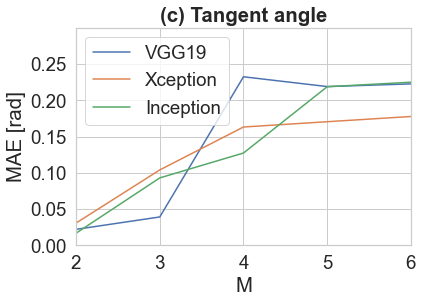

In [7]:
sns.set_theme(style="whitegrid", font_scale=1.7)
s = sns.lineplot(data=df_error_tang, x="Number of forces", y="Mean absolute error", hue="Model")
s.set(ylim = (0,0.3), xlim = (2,6))
s.set(xticks = np.arange(2,7,1))
s.set(yticks = np.arange(0,0.3,0.05))
s.set_title('(c) Tangent angle',fontdict= {'fontweight':'bold'})
s.set(xlabel = 'M',
     ylabel = 'MAE [rad]')
plt.legend(loc='upper left')
plt.savefig(os.path.join(plots_path, 'angles_tang_error.pdf'),
            dpi=300, bbox_inches='tight')

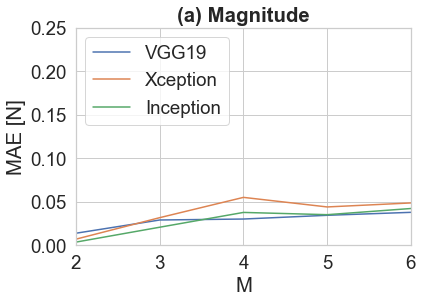

In [8]:
sns.set_theme(style="whitegrid", font_scale=1.7)
s = sns.lineplot(data=df_error_mag, x="Number of forces", y="Mean absolute error", hue="Model")
s.set(ylim = (0,0.1), xlim = (2,6))
s.set(xticks = np.arange(2,7,1))
s.set(yticks = np.arange(0,0.3,0.05))
s.set_title('(a) Magnitude',fontdict= {'fontweight':'bold'})
s.set(xlabel = 'M',
     ylabel = 'MAE [N]')
plt.legend(loc='upper left')
plt.savefig(os.path.join(plots_path, 'magnitude_mae_error.pdf'),
            dpi=300, bbox_inches='tight')

#### Plot Magnitudes in Bins (MAE and MAPE)

In [12]:
with open(os.path.join(plots_path, "magnitude_mape_vgg19.pkl"), "rb") as fh:
  df_error_mape_vgg19 = pkl.load(fh)
with open(os.path.join(plots_path, "magnitude_mape_xception.pkl"), "rb") as fh:
  df_error_mape_xception = pkl.load(fh)
with open(os.path.join(plots_path, "magnitude_mape_inception.pkl"), "rb") as fh:
  df_error_mape_inception = pkl.load(fh)

In [13]:
equiv = {'2 forces': 'M = 2', '3 forces' : 'M = 3', '4 forces' : 'M = 4',
        '5 forces' : 'M = 5', '6 forces' : 'M = 6'}
df_error_mape_vgg19['M'] = df_error_mape_vgg19['Forces'].map(equiv)
df_error_mape_vgg19 = df_error_mape_vgg19.drop(columns = 'Forces')

df_error_mape_xception['M'] = df_error_mape_xception['Forces'].map(equiv)
df_error_mape_xception = df_error_mape_xception.drop(columns = 'Forces')

df_error_mape_inception['M'] = df_error_mape_inception['Forces'].map(equiv)
df_error_mape_inception = df_error_mape_inception.drop(columns = 'Forces')

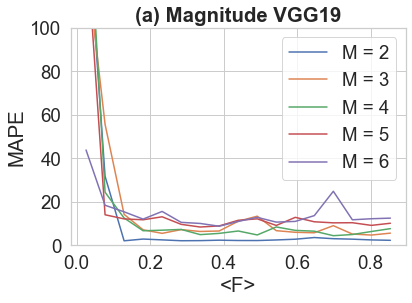

In [14]:
df_error_mape_vgg19 = df_error_mape_vgg19[df_error_mape_vgg19['Mean bin magnitude'] <= 0.9]

sns.set_theme(style="whitegrid", font_scale=1.7)
s = sns.lineplot(data=df_error_mape_vgg19, x="Mean bin magnitude", y="Mean absolute percent error", hue="M")
s.set(ylim = (0,100))
s.set(xlabel = '<F>',
     ylabel = 'MAPE')
s.set_title('(a) Magnitude VGG19',fontdict= {'fontweight':'bold'})
plt.legend(loc='upper right')
plt.savefig(os.path.join(plots_path, 'magnitude_percent_error_vgg19.pdf'), dpi=300, bbox_inches='tight')

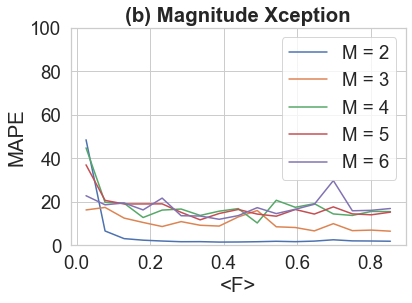

In [15]:
df_error_mape_xception = df_error_mape_xception[df_error_mape_xception['Mean bin magnitude'] <= 0.9]

sns.set_theme(style="whitegrid", font_scale=1.7)
s = sns.lineplot(data=df_error_mape_xception, x="Mean bin magnitude", y="Mean absolute percent error", hue="M")
s.set(ylim = (0,100))
s.set(xlabel = '<F>',
     ylabel = 'MAPE')
s.set_title('(b) Magnitude Xception', fontdict= {'fontweight':'bold'})
plt.legend(loc='upper right')
plt.savefig(os.path.join(plots_path, 'magnitude_percent_error_xception.pdf'), dpi=300, bbox_inches='tight')

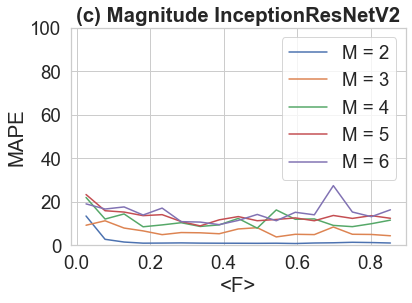

In [17]:
df_error_mape_inception = df_error_mape_inception[df_error_mape_inception['Mean bin magnitude'] <= 0.9]

sns.set_theme(style="whitegrid", font_scale=1.7)
s = sns.lineplot(data=df_error_mape_inception, x="Mean bin magnitude", y="Mean absolute percent error", hue="M")
s.set(ylim = (0,100))
s.set(xlabel = '<F>',
     ylabel = 'MAPE')
s.set_title('(c) Magnitude InceptionResNetV2',fontdict= {'fontweight':'bold'})
plt.legend(loc='upper right')
plt.savefig(os.path.join(plots_path, 'magnitude_percent_error_inception.pdf'), dpi=300, bbox_inches='tight')